In [38]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
# draws the plot inline in jupyter notebook instead of opening in a new window

In [39]:
def f(x):
    return 3*x**2 - 4*x + 5

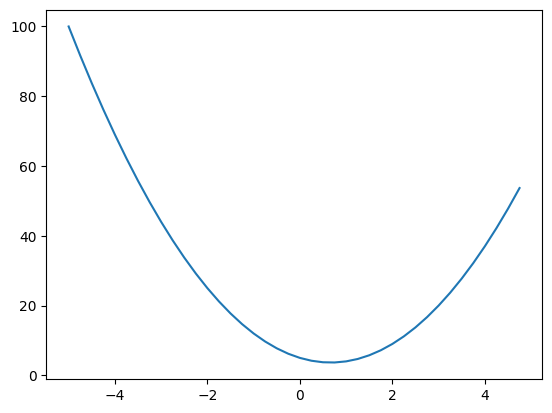

In [40]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, f(xs))

In [17]:
'''
Derivative

L = lim (h->0) (f(x+h) - f(x))/h
If you slightly increase x by small number h then how does the function respond by what sensitivity (slope of the response at a point)

Derivative = rise/run
'''

h = 0.001 # floating point arithmetic, too many 0's can lead to 0
x = 3.0
(f(x + h) - f(x))/h

14.00300000000243

In [18]:
'''
Another example for derivative
'''
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c

print(f'dd/da = {(d2 - d1) / h}') # dd/da = d (a*b + c)/da = b

a = 2.0 # reset
d1 = a*b + c
b += h
d2 = a*b + c

print(f'dd/db = {(d2 - d1) / h}') # dd/db = d (a*b + c)/da = a

b = -3.0 # reset
d1 = a*b + c
c += h # If c becomes slightly bit higher, then output d will be come slightly bit higher by the same amount because we are adding c
d2 = a*b + c

print(f'dd/dc = {(d2 - d1) / h}') # dd/dc = d (a*b + c)/dc = 1, 

dd/da = -3.000000000010772
dd/db = 2.0000000000042206
dd/dc = 0.9999999999976694


In [41]:
'''
We will move to neural networks. Neural networks will be massive mathematical expressions and we need data structures to maintain these
expressions. Creating a Value node using which we will be able to build an expression graph
'''

class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        '''
        data: value of the node
        _children: will be tuple for convenience and when we maintain it in the class it will be a set of tuples for efficiency
        _prev: children of the node from which the current node was derived or built
        label: name of the node
        grad: gradient, signifies the rate of change of output with respect to current node, that is, it determines how a small change 
        in input (data) will affect the output (o), do/dx
        '''
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0 # by default we assume this is 0, we assume that changing this variable will not impact the out
        self._backward = lambda: None # function which will perform chain rule, that takes input and produces output. We will store how we will chain
        # output gradient into the input gradient. By default it will not do anything, empty function, for eg leaf node which doesnt do 
        # anything

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        '''
        when two value objects 'a' and 'b' are added, a + b, python will internally call, a.__add__(b), b will be other and self will be a
        '''
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out
        
    def __radd__(self, other):
        return self + other
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out

    def __rmul__(self, other): # other * self
        '''
        when operation is 2 * a, then python will call 2.__mul__(a) and it will not know how to multiply a, but it will check if a knows
        how to multiply with 2, and it will check if has rmul 
        '''
        return self * other

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self, ), _op = f'**{other}')
        def _backward():
            self.grad += other * self.data**(other - 1) * out.grad 
        out._backward = _backward
        return out

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __neg__(self): # -self
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other)

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad # out.data**2

        out._backward = _backward
        return out
        
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), _op = 'exp')
        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward
        
        return out

    def backward(self):
        '''
        Topological sort: to automatically call _backward for each node from right to left
        '''
        self.grad = 1.0
        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        for node in reversed(topo):
            node._backward()

In [156]:
a = Value(2.0)
b = Value(4.0)
a - b

Value(data=-2.0)

In [23]:
a = Value(2.0); a.label = 'a'
b = Value(-3.0); b.label = 'b'
c = Value(10.0); c.label = 'c'
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d*f; L.label = 'L'
L

Value(data=-8.0)

In [42]:
'''
Helps visualize the expression graph
'''
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
            
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot

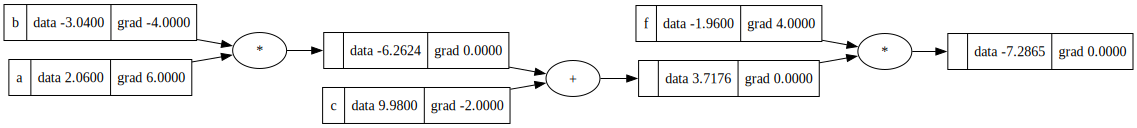

In [43]:
draw_dot(L)

In [26]:
'''
L = d * f
Lets calculate dL/dd manually.

dy/dx = (f(x+h) - f(x))/h

Increasing d by h.

dL/dd = ((d+h) * f - d*f)/h = (df + hf - df)/h = hf/h = f

Derivative of a sum expression:

d = c + e 

dd/dc = d (c + e)/dc = 1
OR
((c+h + e) - (c+e))/h = 1

Also called as "Local Derivative" because we have the final output value all the way at the end of the graph and we now have a small node 
here and this is a little plus node which does not know rest of the graph. All it knows is that its a plus. It takes c and e, add them to get
d. The plus node knows the added influence of c on d or rather the derivate of d wrt to c or wrt to e. This is just a local derivative.

What we need is dL/dc. 

Answer: Chain Rule

dz/dx = dz/dy * dy/dx (Chaining derivatives together. To differentiate through function composition we have to apply a multiplication of 
those derivatives.)

Example: If a car travels twice as fast as a bicycle and bicycle travels 4 times as fast as a man, then car travels 2*4 = 8 times as fast 
as a man.
'''

L.grad = 1.0 # If I change L by a tiny amount h how much does L change, it changes by h
d.grad = 1 * f.data # dL/dd = d (d*f)/dd = f * dd/dd (scalar multiplication) = 1 * f
f.grad = 1 * d.data # same as above
c.grad = 1 * d.grad # dL/dc = dL/dd * dd/dc (chain rule) = d.grad * dd/dc = d.grad * d (c+e)/dd = d.grad * (dc/dc + de/dc) = d.grad * (1+0)
e.grad = 1 * d.grad # in case of addition, gradient of children will be same as parent, step increase in child will have same affect on output
b.grad = e.grad * a.data  # dL/db = dL/de * de/db = e.grad * a = d.grad * a
a.grad = e.grad * b.data

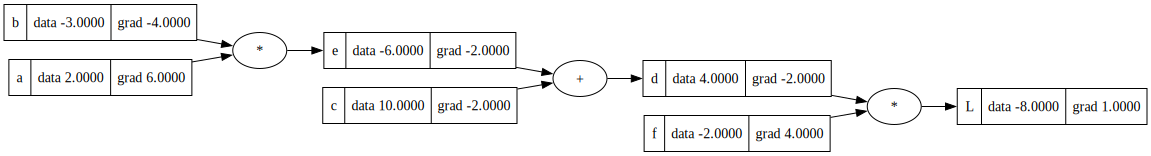

In [27]:
draw_dot(L)

In [28]:
def inline_gradient_check():
    '''
    Inline gradient check
    Gradient check: when we are deriving this back propagation and getting derivative wrt to all the intermediate results
    Numerical gradient: is estimating it using small step size
    '''
    h = 0.0001
    
    a = Value(2.0); a.label = 'a'
    b = Value(-3.0); b.label = 'b'
    c = Value(10.0); c.label = 'c'
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f; L.label = 'L'
    L1 = L.data
    
    a = Value(2.0); a.label = 'a'
    b = Value(-3.0 + h); b.label = 'b'
    c = Value(10.0); c.label = 'c'
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f; L.label = 'L'
    L2 = L.data

    print((L2 - L1) / h) # rise/run, dL/da, how much has L changed and normalize it by h

inline_gradient_check()

-4.000000000008441


In [29]:
'''
If a increases in the direction of gradient by a small step size then we expect positive influence on L
'''
print("L.data before change = ", L.data)

a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a*b
d = e + c
L = d*f

print("L.data after change = ", L.data)

L.data before change =  -8.0
L.data after change =  -7.286496


In [30]:
'''
Back propagation through a Neuron. We want to eventually build neural networks. In the simplest case these are called,
multi layer perceptrons (a two layer neural net).

Biologically neurons are very complicated devices, but we have very simple mathematical model of them.
"neuron" is a mathematical function or node in a network that takes input, processes it (typically through a 
weighted sum and activation function), and produces an output to the next layer of neurons.

You have some inputs, x's and synapses or weights called w's. Synapse interacts with inputs to the neuron multiplicatively. 
What flows to the cell body of neuron is w*x, but there are multiple inputs so it is Sum(wi * xi). Cell body has also some bias, this is 
like a innate trigger happiness of this neuron. This bias can trigger more happy or less happy regardless of the input.

Activation function is some kind of a squashing function like a sigmoid or tanh.
What comes out of the neuron is the activation function = SUM(wi*xi) + b

Sigmoid = 1/(1 + e^-x)

Tanh (hyperbolic function) = (e^x - e^-x)/(e^x + e^-x) = (e^2x - 1) / (e^2x + 1)

Hyperbolic functions are defined using hyperbola instead of a circle (trignometric functions).
Tanh: Maps real numbers between range of (-1, 1).
For large positive inputs, tanh(x) approaches 1, and for large negative inputs, it approaches -1. 
For inputs close to 0, tanh(x) is approximately equal to its input, i.e., tanh(0) = 0.

In neural networks, tanh is often used as an activation function for hidden layers because:

1. It is zero-centered, meaning it produces both positive and negative outputs, which can lead to faster convergence during training 
compared to the sigmoid function.
2. It compresses the input into a small range, which helps normalize and stabilize neural network outputs.


Summary:
1. Neural network: consists of inputs (x's), weights (w's) and a bias (independent of input that can influence the output)
2. Activation function: tanh, used in neural networks for its properties (zero centered and small range of (-1, 1))
'''

# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2 (synaptic strings for each input)
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1x2w2'
# cell body raw activation without the activation function (tanh)
n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label = 'o' 

o.backward()

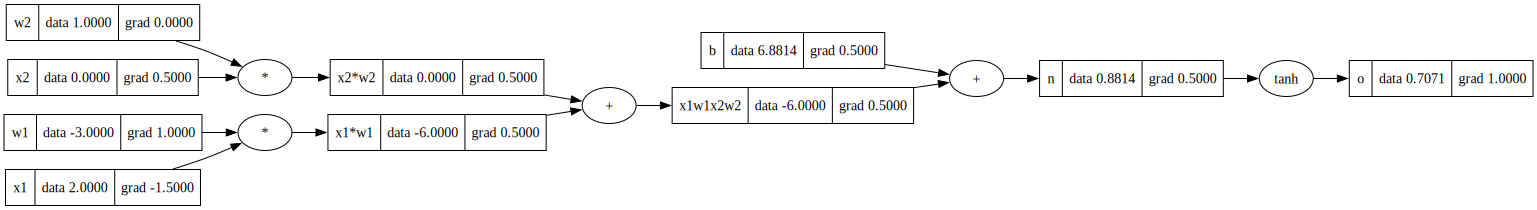

In [31]:
draw_dot(o)

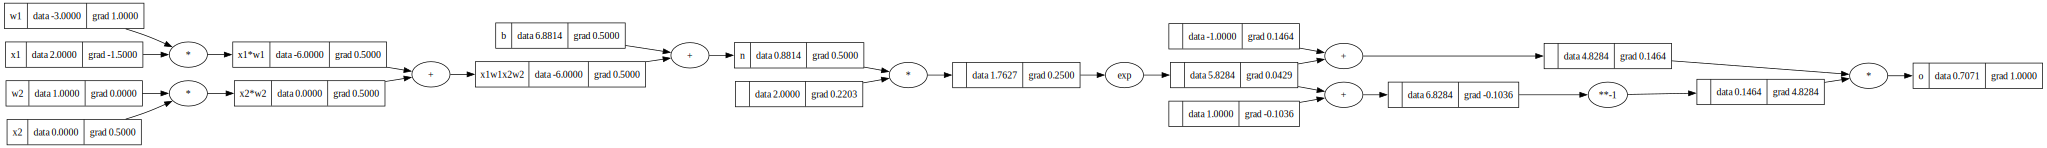

In [32]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2 (synaptic strings for each input)
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1x2w2'
# cell body raw activation without the activation function (tanh)
n = x1w1x2w2 + b; n.label='n'
# --- 
e = (2*n).exp()
o = (e - 1) / (e + 1)
#o = n.tanh(); o.label = 'o' 
# ----
o.label = 'o'
o.backward()

draw_dot(o)

In [33]:
o.grad = 1.0
o._backward()
n._backward()
b._backward # empty function, nothing happens
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

In [84]:
'''
What is the derivative of o wrt to all of the inputs (x's and w's). In a typical neural network setting what we care about the most is the
derivative wrt to the weights specifically as those are the weights we will be changing as part of the optimization.

Here we have only a single neuron but in the neural network we have many neurons that are typically connected. This is only like a one small 
neuron and piece of a much bigger puzzle and eventually there is a loss function that measures the accuracy of the neural net and we are back
propagating wrt to that accuracy in trying to increase it. 
'''

o.grad = 1.0 # base case, do/do

In [89]:
n.grad = 0.5 #1 - o.data**2 # do/dn = d (tanh n)/dn = 1 - tanh(n)**2 = 1 - o**2 # o = tanh(n)
x1w1x2w2.grad = n.grad
b.grad = n.grad
x1w1.grad = x1w1x2w2.grad # do/dx1w1
x2w2.grad = x1w1x2w2.grad # do/dx2w2
x1.grad = x1w1.grad * w1.data #do/dx = do/dx1w1 * dx1w1/dx1 = x1w1.grad * w1
w1.grad = x1w1.grad * x1.data
x2.grad = x2w2.grad * w2.data
w2.grad = x2w2.grad * x2.data

In [ ]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b ; d.label = 'd'
e = a + b ; e.label = 'e'
f = d * e ; f.label = 'f'

f.backward()

draw_dot(f)

In [44]:
'''
Micrograd is a scalar valued engine
Pytorch is based on Tensors. Tensors are n-dimensional arrays of scalars
Scalar valued tensor: single element
'''

import torch

In [45]:
'''
Python uses double precision by default fload64
By default data type of tensors will be float32. Hence casting it to double.

Because below one's are leaf nodes by default pytorch assumes they do not require a gradient. Hence need to explicitly say that they require
gradients. It is set to false by default for efficiency reasons. Usually you would not want to set gradients for leaf nodes, like the inputs
to the network and this is trying to be efficient in most common cases.

We can do lots of operations with tensors in parallel and hence they are very efficient. Otherwise micrograd agrees to the APIs of PyTorch
'''

x1 = torch.Tensor([2.0]).double()              ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()              ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()             ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()              ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

'''
Similar to micrograd, tensors have .data and .grad. The only difference here is that we need to call .item()
.item(): takes single tensor of one element and returns that element stripping out the tensor
'''
print(o.data.item())
o.backward()

print('___')
print('x1', x1.grad.item())
print('x2', x2.grad.item())
print('w1', w1.grad.item())
print('w2', w2.grad.item())

0.7071066904050358
___
x1 -1.5000003851533106
x2 0.5000001283844369
w1 1.0000002567688737
w2 0.0


In [46]:
o

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

In [124]:
'''
Neural nets are a specific class of mathematical expressions. 

Implement a neuron that also subscribes to the PyTorch API's and how it designs its neural network modules. 
'''

class Neuron:
    def __init__(self, nin):
        '''
        nin: number of inputs, how many inputs come to a neuron
        w: weights within range of (-1, 1) for each input
        b: bias that controls the overall trigger happiness of the neuron
        '''
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        '''
        Forward pass of a single neuron
        
        zip: takes two iterators and it creates a new iterator that iterates on the tuples of the corresponding entries
        '''
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)# raw activation
        out = act.tanh() # pass the raw activation through non linearity
        return out
        
    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        '''
        Layer is a list of neurons
        nout: how many neurons within a layer, which is number of outputs in this layer
        nin: 
        '''
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
        
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        '''
        params = []
        for neurons in self.neurons:
            ps = neuron.parameters()
            params.extend(ps)
        return params
        '''

class MLP:
    def __init__(self, nin, nouts):
        '''
        nin: number inputs per neuron
        nouts: list of neurons per layer
        '''
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
        
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.8818111137004163)

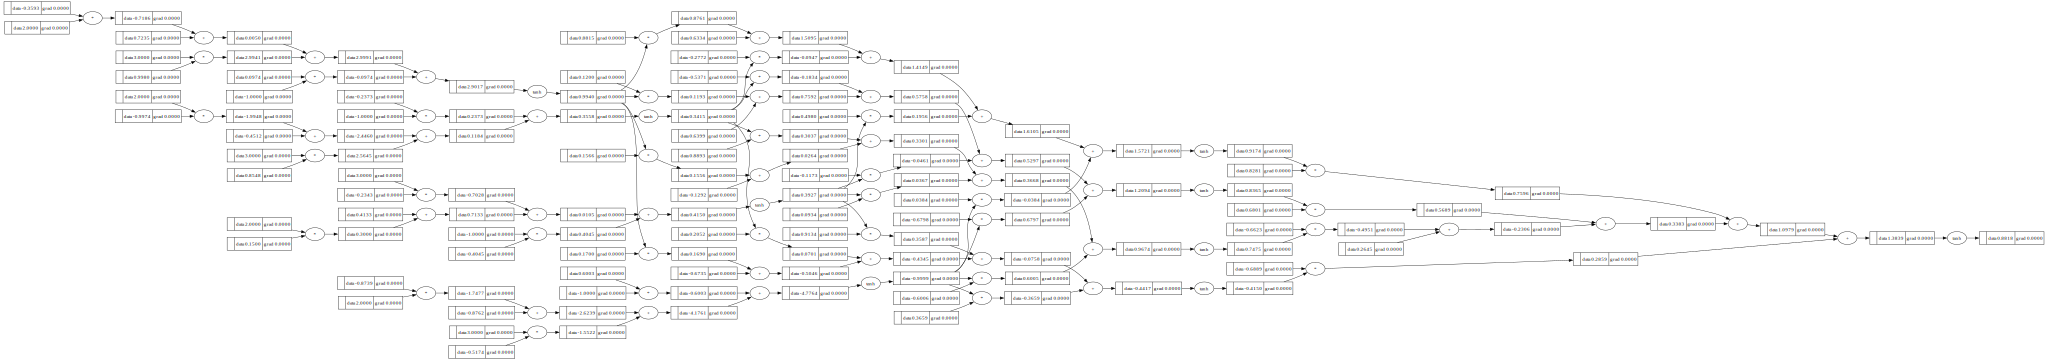

In [125]:
draw_dot(n(x))

In [126]:
'''
Binary classifier neural net
xs: different inputs
ys: desired output per input
'''

xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

ypred = [n(x) for x in xs]
ypred

[Value(data=0.8818111137004163),
 Value(data=0.9634532759323443),
 Value(data=0.9645549119247774),
 Value(data=0.93465340540722)]

In [127]:
'''
The trick used in Deep Learning to achieve these desired targets is to calculate a single number that somehow measures the total performance 
of the neural network. We call this single number as loss.

Measures how well the neural net is performing. Right now the loss is high becauses the ypred is not close to ys. We want to minimize the loss

We will implement the mean squared error loss

ygt: y ground truth
yout: y output
'''

loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=7.732863559006834)

In [128]:
loss.backward()

In [129]:
'''
Gradients on the input data are not useful as inputs are fixed and we will not change them

Some of them are the neural network parameters which are w's and b. These are the once we want to change to reduce loss function.
'''

n.layers[0].neurons[0].w[0].grad

0.097761461280427

In [130]:
len(n.parameters())

41

In [ ]:
'''
Gradient descent: Change p.data slightly according to the gradient information. We are thinking of the gradient as a vector pointing in the 
direction of increased loss. Modify it by a small step size (eg: 0.01) in the direction of the gradient
'''
for p in n.parameters():
    p.data += 0.01 * p.grad